# MODELING

## PROBLEM DEFINITION AND GOALS

**We aim to model, predict, and simulate foreign aid dynamics for Kenya.**  

### CORE MODELING OBJECTIVES

1. **Aid Flow Stability And Volatility Analysis**  
   - Goal: Identify which sectors, agencies, and partners are most stable, volatile, or dominant in aid delivery.  
   - Approach:  
     - Compute volatility metrics (rolling std, coefficient of variation).  
     - Classify entities using unsupervised clustering or ranking.  
     - Highlight dominant vs. emerging actors.

2. **Predictive And Scenario Forecasting**  
   - Goal: Predict future funding flows or simulate policy shocks (e.g., “25% cut in USAID funding”).  
   - Approach: 
     - Use regression models (XGBoost, Random Forest, Prophet) on aid totals.  
     - Simulate counterfactual scenarios by adjusting model inputs.

3. **Temporal Forecasting And Shock Simulation**  
   - Goal: Model aid trends across fiscal years and assess resilience to fiscal shocks.  
   - Approach:  
     - Time series forecasting (Prophet, ARIMA, LSTM).  
     - Introduce synthetic shocks to test system response.

4. **Sectoral Dependency Clustering**  
   - Goal: Cluster sectors by their dependency on foreign aid.  
   - Approach:  
     - Use KMeans, DBSCAN, or hierarchical clustering.  
     - Base features on aid ratios and concentration metrics.

## DATA AUDIT

### STRONG COLUMNS
Provide robust quantitative and categorical anchors:
- Temporal: fiscal_year, transaction_date, year, quarter
- Categorical Context: country_name, us_sector_name, us_category_name
- Management Context: managing_subagency_or_bureau_name, funded_and_managed_by, dominant_sector_per_agency
- Monetary & Variability Indicators:  
  current_dollar_amount, constant_dollar_amount, total_aid_fiscal,  
  aid_volatility, rolling_mean_3yr, rolling_std_3yr, aid_concentration_index,  
  top3_agency_share, sector_to_total_ratio, agency_to_total_ratio,  
  aid_per_partner, relative_aid_share, aid_std_fiscal,  
  mean_aid_per_transaction_fiscal

### COLUMNS THAT NEED ATTENTION
- objective, transaction_type_name -> will need grouping or encoding.  
- transaction_lag, transaction_lead -> align correctly with fiscal years.    

### COLUMNS TO DROP
- transaction_date -> replace with derived temporal features.  
- country_name -> constant for Kenya, can be dropped.  
- Columns ending in _interaction -> use dimensionality reduction (PCA) or selective inclusion.

## WORKFLOW

### DATA PREPARATION
1. Handle missingness with appropriate imputations.  
2. Normalize skewed monetary variables (we will use log1p).  
3. Encode categorical variables using **target encoding** or **frequency encoding**.  
4. Aggregate aid data by **year**, **sector**, or **agency** depending on the model goal.  
5. Split data chronologically (e.g train up to 2019, test from 2020 onward).

### FEATURE ENGINEERING CONSIDERATIONS
- Rolling averages: rolling_mean_3yr, rolling_std_3yr, sector_growth_rate, agency_growth_rate
- Concentration & diversity: aid_concentration_index, aid_diversity_index
- Ratios: sector_to_total_ratio, agency_to_total_ratio
- Interaction terms: agency_sector_interaction, partner_agency_interaction

### TARGET PICKING

| Objective | Problem Type | Model Candidates | Key Targets |
|------------|---------------|------------------|--------------|
| **Stability & Volatility** | Unsupervised / Ranking | KMeans, Isolation Forest, PCA, TS Clustering | aid_volatility, aid_concentration_index |
| **Predictive Forecasting** | Supervised Regression | XGBoost, LightGBM, Prophet | total_aid_fiscal, constant_dollar_amount |
| **Temporal Forecasting** | Time Series | Prophet, ARIMA, LSTM | total_aid_fiscal, sector_to_total_ratio |
| **Sector Dependency** | Clustering | KMeans, Spectral, DBSCAN | sector_to_total_ratio, aid_per_partner, aid_concentration_index |

### EVALUATION METRICS
- **Regression Models:** RMSE, MAE, MAPE, R²  
- **Forecasting Models:** MAPE, RMSE, Directional Accuracy  
- **Clustering Models:** Silhouette Score, Calinski-Harabasz Index  
- **Volatility Analysis:** Rolling std comparison, stability ranking

### SCENARIO SIMULATION
Run post-model scenario experiments:
- Introduce a **shock factor**, e.g., USAID_cut = -0.25  
- Recompute predicted totals and compare to baseline.  
- Measure cascading impacts by sector (sector_to_total_ratio shifts).  
- Visualize using waterfall charts or delta bar plots.

### VISUALS
- **Time Series:** Aid trends per sector/agency.  
- **Heatmaps:** Volatility or concentration over time.  
- **Cluster Maps:** Sector dependency visualization.  
- **Scenario Dashboards:** Policy or funding cut simulations.

In [1]:
# ------- [Import all relevant libraries] -------

# General Utilities
import warnings
warnings.filterwarnings('ignore')

import numpy as np                          # Numerical computing
import pandas as pd                         # Data manipulation and analysis
import datetime as dt                       # Date/time operations
import re                                   # String manipulation
from collections import Counter             # Frequency counting
import logging

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Feature Engineering & Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
)
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
)
from sklearn.decomposition import PCA, TruncatedSVD

# Machine Learning Models
# ======================

## Supervised Learning (Regression/Prediction)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## Unsupervised Learning (Volatility and Dependency Clustering)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Time Series & Forecasting
from statsmodels.tsa.arima.model import ARIMA
# !pip install prophet
from prophet import Prophet

# Evaluation Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, calinski_harabasz_score
)

# # Imbalanced Data Handling
# from imblearn.over_sampling import SMOTE

# Model Interpretation & Explainability
# !pip install eli5
from lime import lime_tabular

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display

import statsmodels.formula.api as smf

In [2]:
# Load modeling dataset
df = pd.read_csv("../Clean Data/clean_data.csv")

# Drop country_name
df.drop(columns=['country_name'], inplace=True)

In [3]:
df.columns

Index(['managing_subagency_or_bureau_name', 'us_category_name',
       'us_sector_name', 'objective', 'transaction_type_name', 'fiscal_year',
       'transaction_date', 'current_dollar_amount', 'constant_dollar_amount',
       'transaction_year', 'transaction_month', 'transaction_quarter',
       'is_end_of_fiscal_year', 'days_since_start_of_year',
       'is_holiday_quarter', 'aid_volatility', 'rolling_mean_3yr',
       'rolling_std_3yr', 'total_aid_fiscal', 'transaction_count_fiscal',
       'mean_aid_per_transaction_fiscal', 'aid_std_fiscal', 'total_sector_aid',
       'avg_sector_aid', 'sector_transaction_count', 'total_agency_aid',
       'avg_agency_aid', 'agency_transaction_count', 'total_partner_aid',
       'partner_transaction_count', 'sector_to_total_ratio',
       'agency_to_total_ratio', 'transaction_lag', 'transaction_lead',
       'sector_growth_rate', 'agency_growth_rate', 'partner_growth_rate',
       'agency_count_fiscal', 'aid_concentration_index', 'top3_agency_share

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68264 entries, 0 to 68263
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   managing_subagency_or_bureau_name  68264 non-null  object 
 1   us_category_name                   68264 non-null  object 
 2   us_sector_name                     68264 non-null  object 
 3   objective                          68264 non-null  object 
 4   transaction_type_name              68264 non-null  object 
 5   fiscal_year                        68264 non-null  int64  
 6   transaction_date                   68264 non-null  object 
 7   current_dollar_amount              68264 non-null  float64
 8   constant_dollar_amount             68264 non-null  float64
 9   transaction_year                   68264 non-null  int64  
 10  transaction_month                  68264 non-null  int64  
 11  transaction_quarter                68264 non-null  int

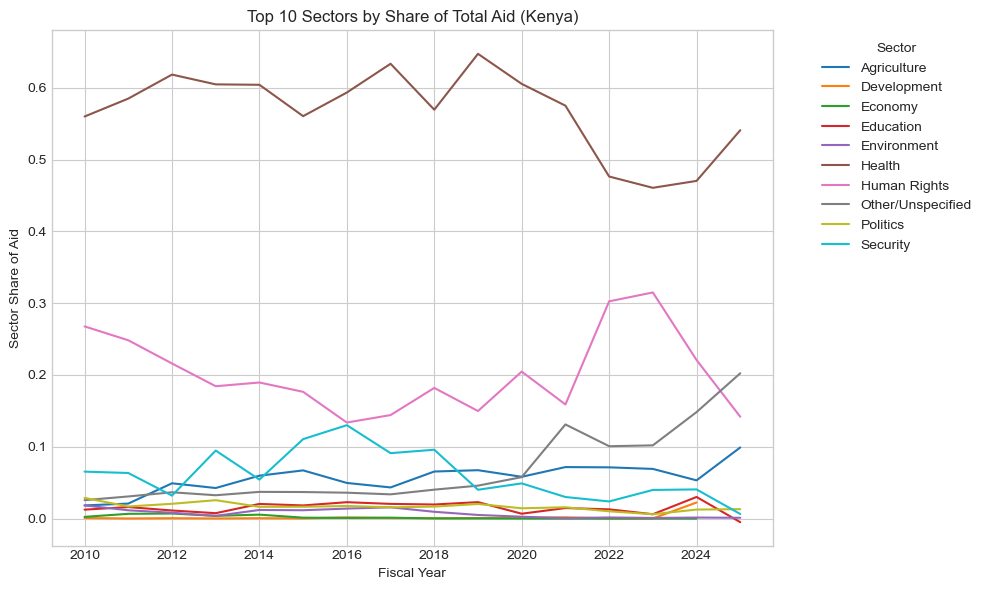

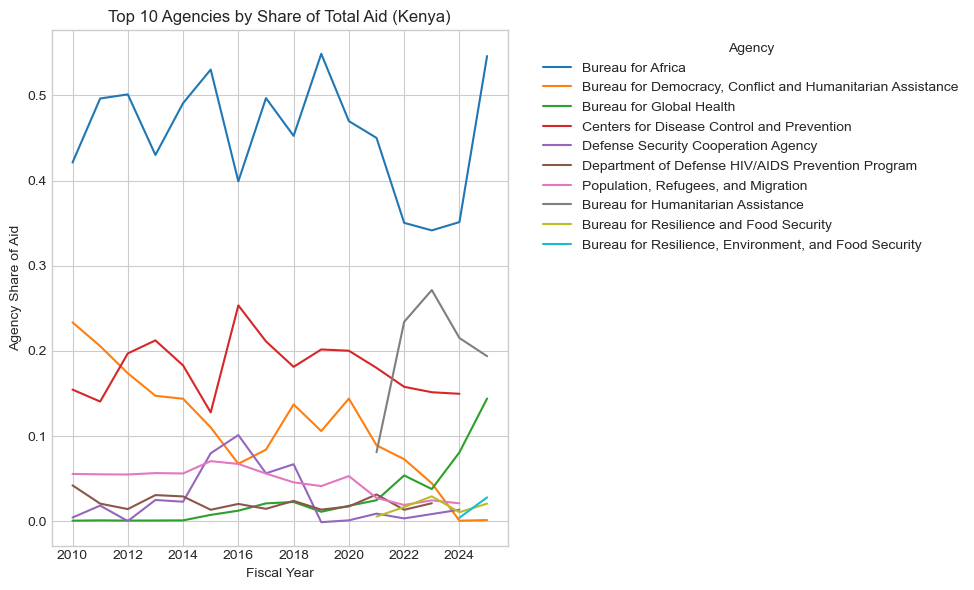

In [5]:
# --- 1. Aggregate & Visualize Kenya’s Aid by Sector and Agency ---

# Aggregate by fiscal year and sector
agg_sector = (
    df.groupby(['fiscal_year', 'us_sector_name'], as_index=False)['constant_dollar_amount']
    .sum()
    .rename(columns={'constant_dollar_amount': 'sector_aid'})
)

# Aggregate by fiscal year and agency
agg_agency = (
    df.groupby(['fiscal_year', 'managing_subagency_or_bureau_name'], as_index=False)['constant_dollar_amount']
    .sum()
    .rename(columns={'constant_dollar_amount': 'agency_aid'})
)

# Compute total aid per fiscal year
total_aid = df.groupby('fiscal_year', as_index=False)['constant_dollar_amount'].sum().rename(columns={'constant_dollar_amount': 'total_aid'})

# Merge totals and compute shares
agg_sector = agg_sector.merge(total_aid, on='fiscal_year', how='left')
agg_sector['sector_share'] = agg_sector['sector_aid'] / agg_sector['total_aid']

agg_agency = agg_agency.merge(total_aid, on='fiscal_year', how='left')
agg_agency['agency_share'] = agg_agency['agency_aid'] / agg_agency['total_aid']

# Top sectors and agencies (average share)
top_sectors = agg_sector.groupby('us_sector_name')['sector_share'].mean().nlargest(10).index
top_agencies = agg_agency.groupby('managing_subagency_or_bureau_name')['agency_share'].mean().nlargest(10).index

# Visualization
plt.figure(figsize=(10,6))
sns.lineplot(data=agg_sector[agg_sector['us_sector_name'].isin(top_sectors)], 
             x='fiscal_year', y='sector_share', hue='us_sector_name')
plt.title('Top 10 Sectors by Share of Total Aid (Kenya)')
plt.ylabel('Sector Share of Aid')
plt.xlabel('Fiscal Year')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=agg_agency[agg_agency['managing_subagency_or_bureau_name'].isin(top_agencies)], 
             x='fiscal_year', y='agency_share', hue='managing_subagency_or_bureau_name')
plt.title('Top 10 Agencies by Share of Total Aid (Kenya)')
plt.ylabel('Agency Share of Aid')
plt.xlabel('Fiscal Year')
plt.legend(title='Agency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Total aid reduction: 18.72% after a 25% cut to top 3 agencies.


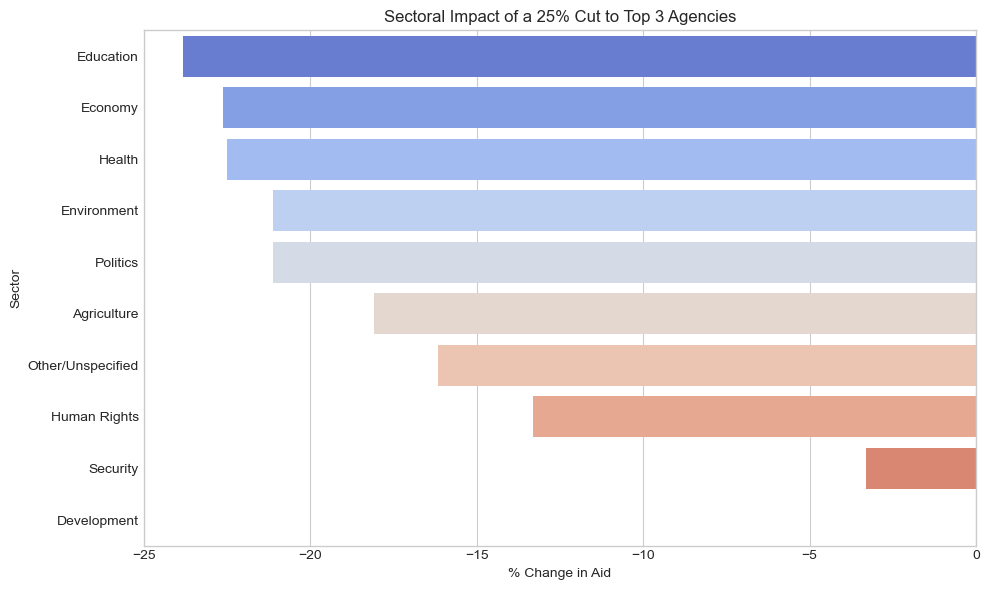

In [6]:
# --- 2. Simulate a 25% Cut to Top 3 Agencies ---

# Find top 3 agencies by total funding
top3_agencies = (
    df.groupby('managing_subagency_or_bureau_name')['constant_dollar_amount']
    .sum()
    .nlargest(3)
    .index
)

# Create a copy for scenario simulation
df_cut = df.copy()

# Apply 25% cut to top 3 agencies
df_cut.loc[df_cut['managing_subagency_or_bureau_name'].isin(top3_agencies), 'constant_dollar_amount'] *= 0.75

# Recalculate total aid and shares
baseline_total = df['constant_dollar_amount'].sum()
cut_total = df_cut['constant_dollar_amount'].sum()
impact_pct = 100 * (1 - cut_total / baseline_total)

print(f"Total aid reduction: {impact_pct:.2f}% after a 25% cut to top 3 agencies.")

# Recompute by sector and agency
agg_baseline = df.groupby('us_sector_name')['constant_dollar_amount'].sum().rename('baseline_aid')
agg_cut = df_cut.groupby('us_sector_name')['constant_dollar_amount'].sum().rename('post_cut_aid')

impact_df = pd.concat([agg_baseline, agg_cut], axis=1)
impact_df['change_%'] = 100 * (impact_df['post_cut_aid'] - impact_df['baseline_aid']) / impact_df['baseline_aid']
impact_df = impact_df.sort_values('change_%')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=impact_df.reset_index(), x='change_%', y='us_sector_name', palette='coolwarm')
plt.title('Sectoral Impact of a 25% Cut to Top 3 Agencies')
plt.xlabel('% Change in Aid')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:         aid_volatility   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.540e+05
Date:                Fri, 31 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:21:28   Log-Likelihood:            -9.7895e+05
No. Observations:               68264   AIC:                         1.958e+06
Df Residuals:                   68259   BIC:                         1.958e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

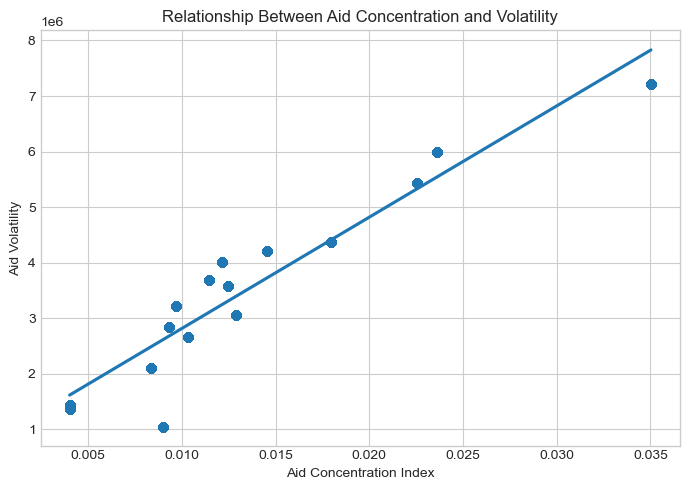

In [7]:
# --- 3. Analyze Volatility vs Concentration Relationship ---

import statsmodels.api as sm

# Prepare variables
analysis_df = df[['aid_volatility', 'aid_concentration_index', 'aid_diversity_index', 
                  'top3_agency_share', 'rolling_std_3yr']].dropna()

# Regression model
X = analysis_df[['aid_concentration_index', 'aid_diversity_index', 'top3_agency_share', 'rolling_std_3yr']]
y = analysis_df['aid_volatility']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Plot relationship (scatter with trend)
plt.figure(figsize=(7,5))
sns.regplot(data=analysis_df, x='aid_concentration_index', y='aid_volatility', scatter_kws={'alpha':0.4})
plt.title('Relationship Between Aid Concentration and Volatility')
plt.xlabel('Aid Concentration Index')
plt.ylabel('Aid Volatility')
plt.tight_layout()
plt.show()

Cluster Summary:
          aid_volatility  aid_concentration_index  aid_diversity_index
cluster                                                              
0          3.898679e+06                 0.014319             1.869138
1          2.081251e+06                 0.008062             1.962567
2          6.110460e+06                 0.024763             1.775228


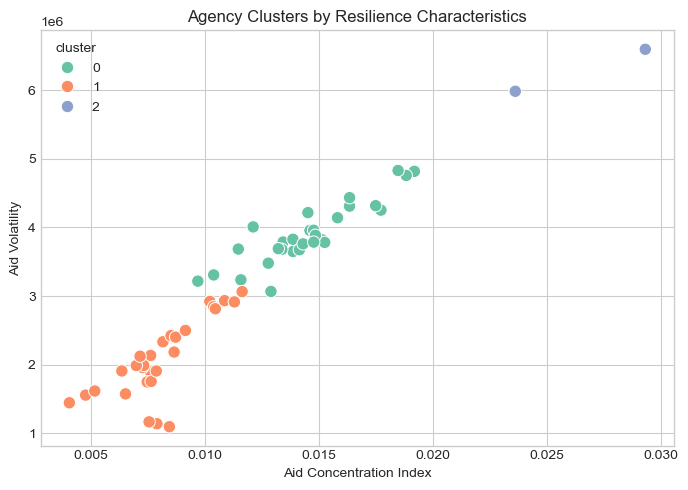

In [8]:
# --- 4. Cluster Agencies by Resilience Characteristics ---

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Compute agency-level aggregates
agency_features = (
    df.groupby('managing_subagency_or_bureau_name', as_index=False)
    [['aid_volatility', 'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share']]
    .mean()
    .dropna()
)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agency_features.drop(columns=['managing_subagency_or_bureau_name']))

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
agency_features['cluster'] = kmeans.fit_predict(X_scaled)

# Label clusters by average volatility
cluster_summary = agency_features.groupby('cluster')[['aid_volatility', 'aid_concentration_index', 'aid_diversity_index']].mean()
print("Cluster Summary:\n", cluster_summary)

# Visualization
plt.figure(figsize=(7,5))
sns.scatterplot(data=agency_features, x='aid_concentration_index', y='aid_volatility', hue='cluster', palette='Set2', s=80)
plt.title('Agency Clusters by Resilience Characteristics')
plt.xlabel('Aid Concentration Index')
plt.ylabel('Aid Volatility')
plt.tight_layout()
plt.show()


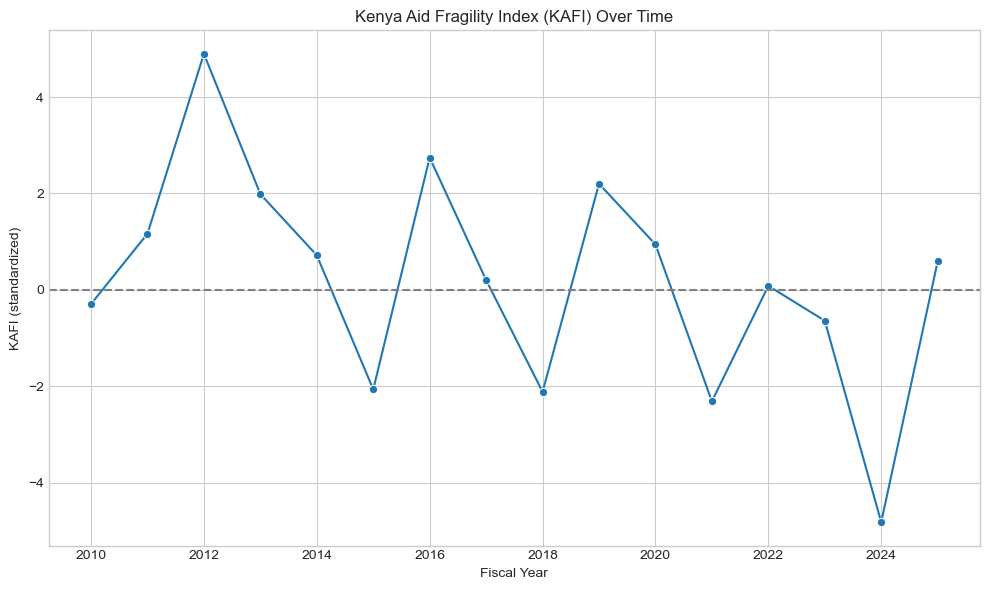

Most Fragile Years:
   fiscal_year      KAFI
2         2012  4.896270
6         2016  2.742188
9         2019  2.199921
3         2013  1.984949
1         2011  1.163667

Most Stable Years:
    fiscal_year      KAFI
14         2024 -4.823128
11         2021 -2.315445
8          2018 -2.118939
5          2015 -2.067485
13         2023 -0.643043


In [9]:
# --- 5. Compute Kenya Aid Fragility Index (KAFI) ---

# Normalize metrics
for col in ['aid_volatility', 'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share']:
    df[f'{col}_z'] = (df[col] - df[col].mean()) / df[col].std()

# Construct KAFI (higher = more fragile)
df['KAFI'] = (
    df['aid_volatility_z'] +
    df['aid_concentration_index_z'] +
    df['top3_agency_share_z'] -
    df['aid_diversity_index_z']
)

# Aggregate by fiscal year
kafi_trend = df.groupby('fiscal_year')['KAFI'].mean().reset_index()

# Visualization
plt.figure(figsize=(10,6))
sns.lineplot(data=kafi_trend, x='fiscal_year', y='KAFI', marker='o')
plt.title('Kenya Aid Fragility Index (KAFI) Over Time')
plt.xlabel('Fiscal Year')
plt.ylabel('KAFI (standardized)')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Inspect top and bottom years
print("Most Fragile Years:")
print(kafi_trend.sort_values('KAFI', ascending=False).head())

print("\nMost Stable Years:")
print(kafi_trend.sort_values('KAFI', ascending=True).head())


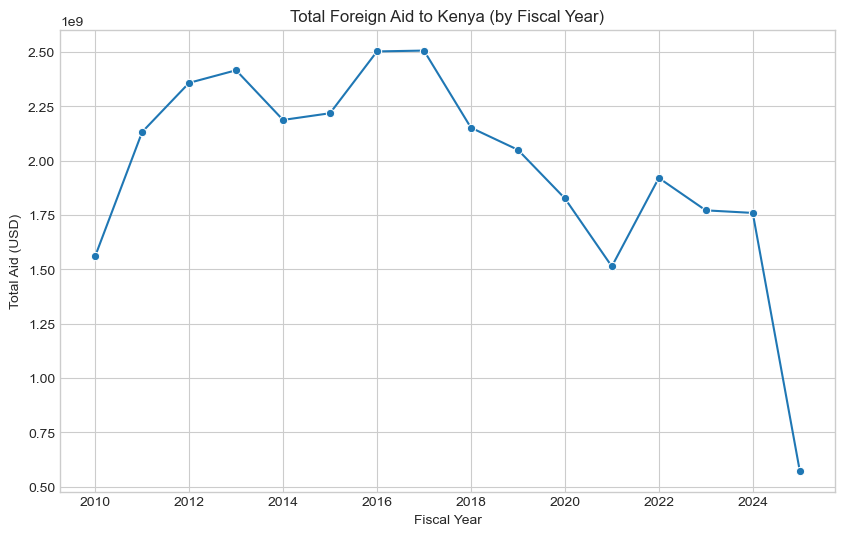

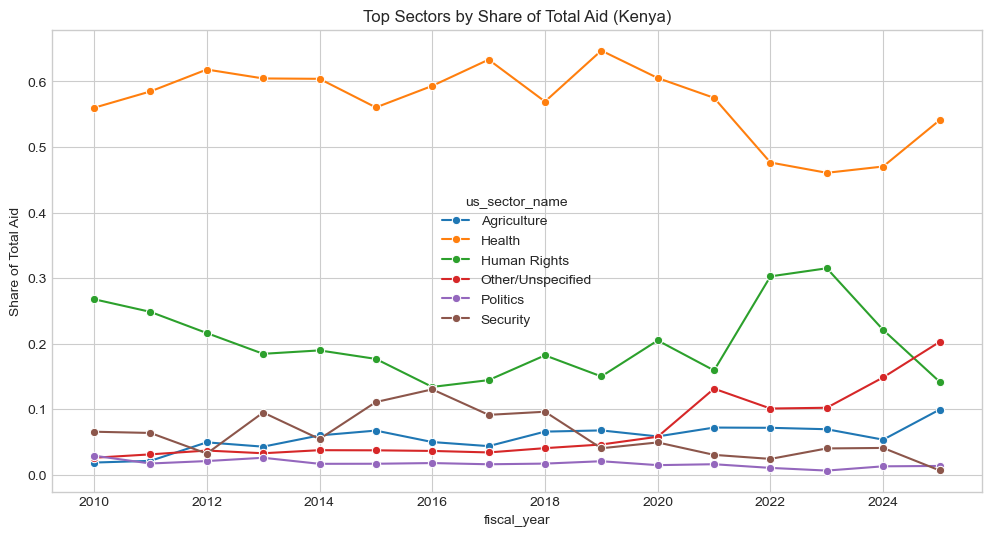

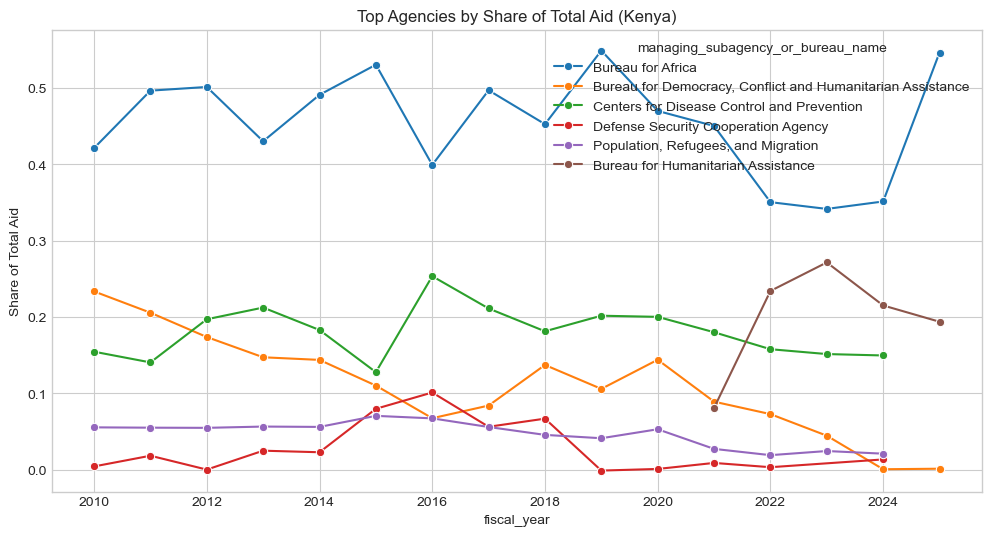

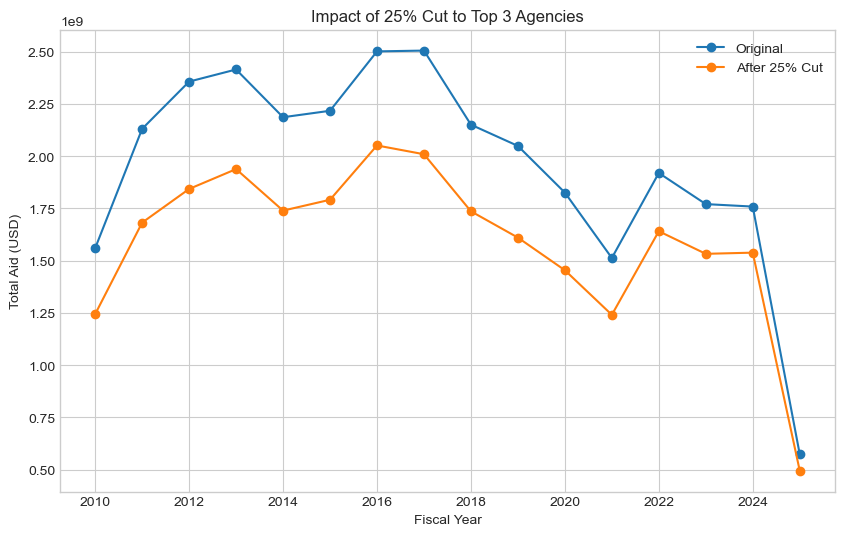


[Simulation] Top 3 agencies affected: Bureau for Africa, Centers for Disease Control and Prevention, Bureau for Democracy, Conflict and Humanitarian Assistance
Overall reduction: 18.72%


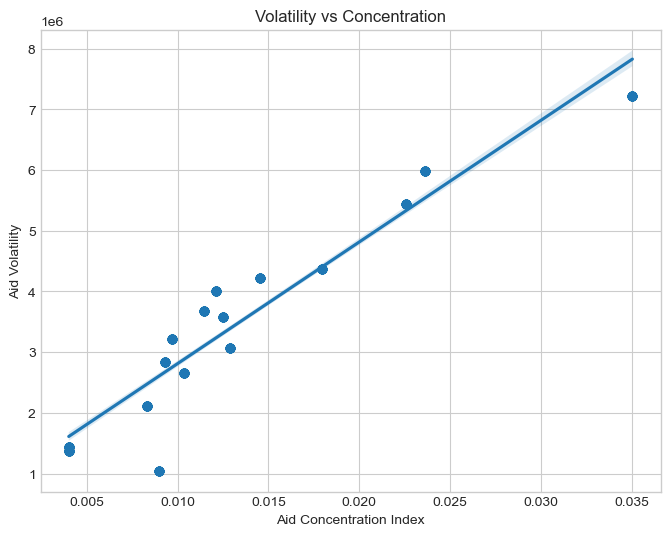

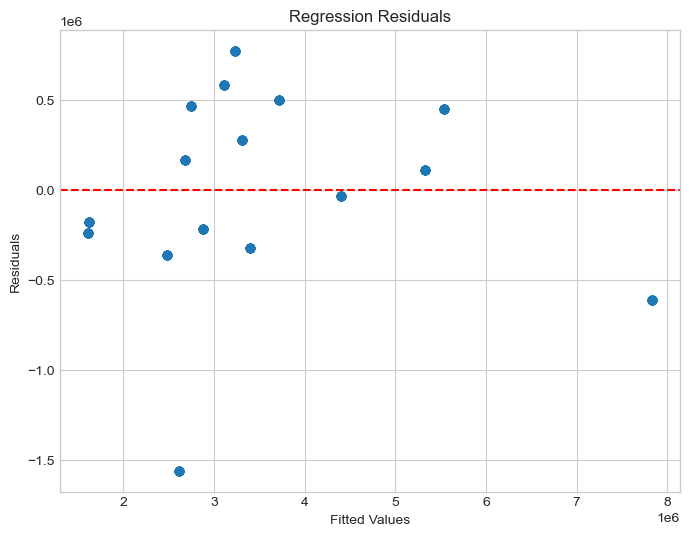

                            OLS Regression Results                            
Dep. Variable:         aid_volatility   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     4480.
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          2.47e-252
Time:                        16:21:41   Log-Likelihood:                -7350.4
No. Observations:                 504   AIC:                         1.470e+04
Df Residuals:                     502   BIC:                         1.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                8

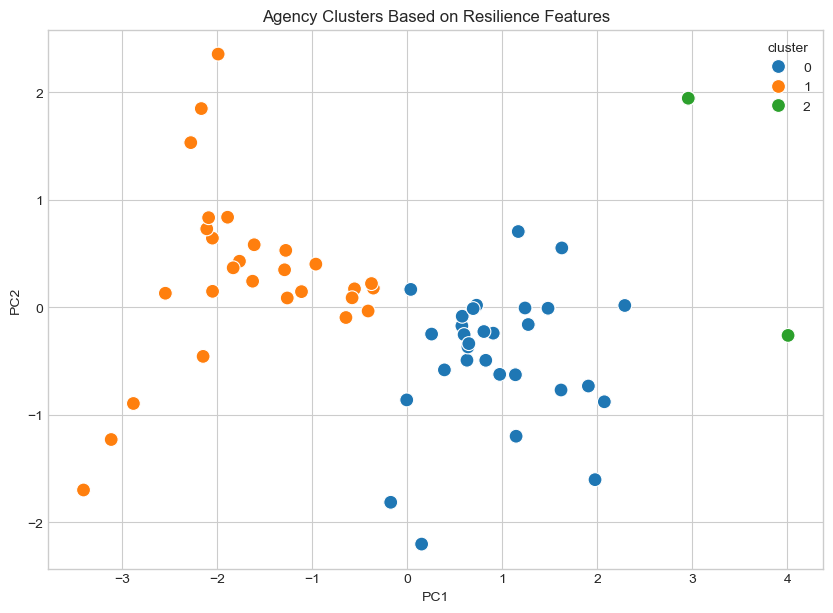


[Clustering Summary]
         avg_volatility  avg_concentration  avg_diversity  avg_top3_share  \
cluster                                                                     
0            3898679.35               0.01           1.87            0.92   
1            2081251.45               0.01           1.96            0.95   
2            6110459.73               0.02           1.78            0.95   

          PC1   PC2  
cluster              
0        0.93 -0.48  
1       -1.66  0.30  
2        3.17  1.50  

[Top 10 Most Fragile Agencies by KAFI]
managing_subagency_or_bureau_name
Democracy, Human Rights, and Labor                   100.0
Animal, Plant and Health Inspection Service          100.0
Patent and Trademark Office                          100.0
Federal Bureau of Investigation                      100.0
Bureau for Economic Growth, Agriculture and Trade     87.9
Trafficking in Persons                                69.5
Office of International and Tribal Affairs            

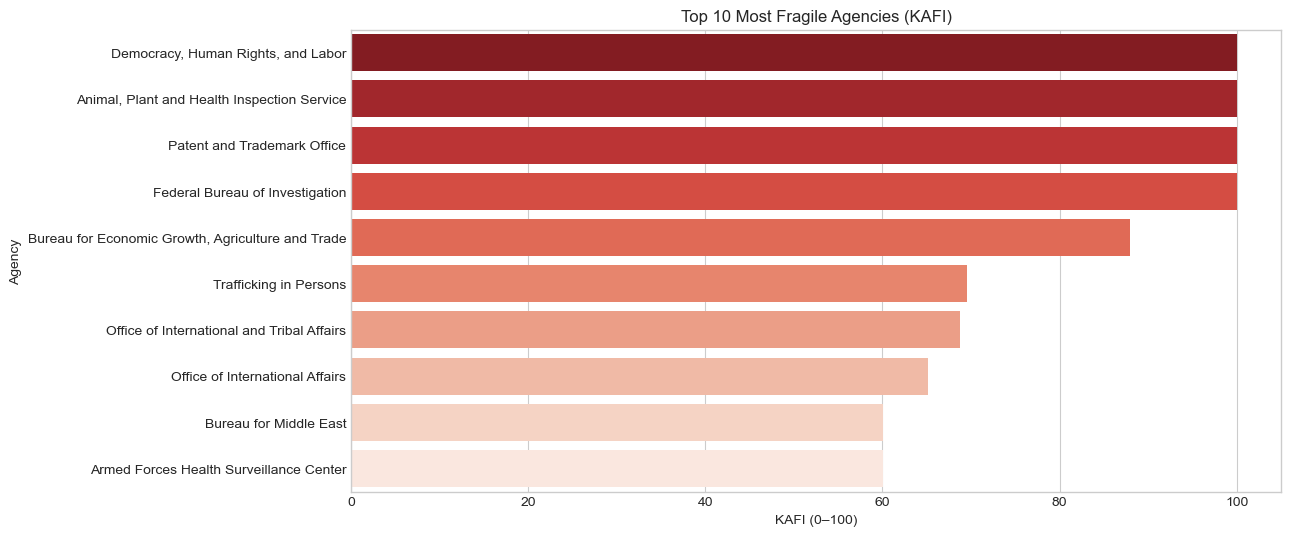

In [10]:
# ----------------------------------------------------------------------
# Aggregate & Visualize Aid Trends

def analyze_aggregates(df):
    AMOUNT = "constant_dollar_amount"
    FISCAL = "fiscal_year"
    SECTOR = "us_sector_name"
    AGENCY = "managing_subagency_or_bureau_name"

    # yearly totals
    total_by_year = df.groupby(FISCAL)[AMOUNT].sum().rename("total_aid")

    # sector breakdown
    agg_sector = (
        df.groupby([FISCAL, SECTOR])[AMOUNT]
        .sum()
        .rename("sector_aid")
        .reset_index()
        .merge(total_by_year, on=FISCAL)
    )
    agg_sector["sector_share"] = agg_sector["sector_aid"] / agg_sector["total_aid"]

    # agency breakdown
    agg_agency = (
        df.groupby([FISCAL, AGENCY])[AMOUNT]
        .sum()
        .rename("agency_aid")
        .reset_index()
        .merge(total_by_year, on=FISCAL)
    )
    agg_agency["agency_share"] = agg_agency["agency_aid"] / agg_agency["total_aid"]

    # ---- Plots ----
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=total_by_year.reset_index(), x=FISCAL, y="total_aid", marker="o")
    plt.title("Total Foreign Aid to Kenya (by Fiscal Year)")
    plt.ylabel("Total Aid (USD)")
    plt.xlabel("Fiscal Year")
    plt.show()

    # Top sectors & agencies
    top_sectors = agg_sector.groupby(SECTOR)["sector_share"].mean().nlargest(6).index
    top_agencies = agg_agency.groupby(AGENCY)["agency_share"].mean().nlargest(6).index

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=agg_sector[agg_sector[SECTOR].isin(top_sectors)],
        x=FISCAL, y="sector_share", hue=SECTOR, marker="o"
    )
    plt.title("Top Sectors by Share of Total Aid (Kenya)")
    plt.ylabel("Share of Total Aid")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=agg_agency[agg_agency[AGENCY].isin(top_agencies)],
        x=FISCAL, y="agency_share", hue=AGENCY, marker="o"
    )
    plt.title("Top Agencies by Share of Total Aid (Kenya)")
    plt.ylabel("Share of Total Aid")
    plt.show()

    return agg_sector, agg_agency, total_by_year


# ----------------------------------------------------------------------
# Simulate Aid Cuts

def simulate_aid_cut(df, cut_fraction=0.25, top_k=3):
    AMOUNT = "constant_dollar_amount"
    FISCAL = "fiscal_year"
    AGENCY = "managing_subagency_or_bureau_name"

    top_agencies = df.groupby(AGENCY)[AMOUNT].sum().nlargest(top_k).index
    df_sim = df.copy()
    df_sim["sim_amount"] = np.where(
        df_sim[AGENCY].isin(top_agencies),
        df_sim[AMOUNT] * (1 - cut_fraction),
        df_sim[AMOUNT],
    )

    baseline = df.groupby(FISCAL)[AMOUNT].sum()
    simulated = df_sim.groupby(FISCAL)["sim_amount"].sum()
    comparison = pd.DataFrame({
        "baseline": baseline,
        "after_cut": simulated,
    })
    comparison["pct_change"] = 100 * (comparison["after_cut"] / comparison["baseline"] - 1)

    # ---- Plot ----
    plt.figure(figsize=(10, 6))
    plt.plot(comparison.index, comparison["baseline"], label="Original", marker="o")
    plt.plot(comparison.index, comparison["after_cut"], label=f"After {int(cut_fraction*100)}% Cut", marker="o")
    plt.title(f"Impact of {int(cut_fraction*100)}% Cut to Top {top_k} Agencies")
    plt.xlabel("Fiscal Year")
    plt.ylabel("Total Aid (USD)")
    plt.legend()
    plt.show()

    # show summary
    print(f"\n[Simulation] Top {top_k} agencies affected: {', '.join(top_agencies)}")
    print(f"Overall reduction: {100 * (1 - simulated.sum() / baseline.sum()):.2f}%")

    return comparison, top_agencies


# ----------------------------------------------------------------------
# Regression: Volatility vs Concentration

def volatility_concentration_model(df):
    FISCAL = "fiscal_year"
    AGENCY = "managing_subagency_or_bureau_name"
    AMOUNT = "constant_dollar_amount"

    if "aid_volatility" not in df.columns:
        df["aid_volatility"] = df.groupby([AGENCY])[AMOUNT].transform(lambda x: x.pct_change().rolling(3).std())

    if "aid_concentration_index" not in df.columns:
        temp = df.groupby([FISCAL, AGENCY])[AMOUNT].sum().groupby(FISCAL)
        hhi = temp.apply(lambda d: (d / d.sum()) ** 2).sum(level=0)
        hhi = hhi.reset_index().rename(columns={AMOUNT: "aid_concentration_index"})
        df = df.merge(hhi, on=FISCAL, how="left")

    panel = (
        df.groupby([FISCAL, AGENCY])
        .agg(aid_volatility=("aid_volatility", "mean"),
             aid_concentration_index=("aid_concentration_index", "mean"))
        .dropna()
        .reset_index()
    )

    model = smf.ols("aid_volatility ~ aid_concentration_index", data=panel).fit()

    # ---- Plot regression ----
    plt.figure(figsize=(8, 6))
    sns.regplot(data=panel, x="aid_concentration_index", y="aid_volatility", scatter_kws={'alpha':0.6})
    plt.title("Volatility vs Concentration")
    plt.xlabel("Aid Concentration Index")
    plt.ylabel("Aid Volatility")
    plt.show()

    # residual plot
    plt.figure(figsize=(8, 6))
    plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Regression Residuals")
    plt.show()

    print(model.summary())
    return model, panel


# ----------------------------------------------------------------------
# Cluster Agencies by Resilience

def cluster_agencies(df, n_clusters=3):
    AGENCY = "managing_subagency_or_bureau_name"

    features = df.groupby(AGENCY).agg(
        avg_volatility=("aid_volatility", "mean"),
        avg_concentration=("aid_concentration_index", "mean"),
        avg_diversity=("aid_diversity_index", "mean"),
        avg_top3_share=("top3_agency_share", "mean"),
    ).fillna(0)

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=25)
    features["cluster"] = km.fit_predict(X)

    # PCA projection for visualization
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(X)
    features["PC1"], features["PC2"] = comps[:, 0], comps[:, 1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=features, x="PC1", y="PC2", hue="cluster", palette="tab10", s=100)
    plt.title("Agency Clusters Based on Resilience Features")
    plt.show()

    print("\n[Clustering Summary]")
    print(features.groupby("cluster").mean().round(2))

    return features


# ----------------------------------------------------------------------
# Kenya Aid Fragility Index (KAFI)
def compute_kafi(df):
    AGENCY = "managing_subagency_or_bureau_name"

    metrics = df.groupby(AGENCY).agg(
        volatility=("aid_volatility", "mean"),
        concentration=("aid_concentration_index", "mean"),
        diversity=("aid_diversity_index", "mean"),
        top3_share=("top3_agency_share", "mean"),
    ).fillna(0)

    z = (metrics - metrics.mean()) / metrics.std(ddof=0)
    metrics["KAFI"] = (
        z["volatility"] + z["concentration"] + z["top3_share"] - z["diversity"]
    )
    metrics["KAFI_0_100"] = 100 * (metrics["KAFI"] - metrics["KAFI"].min()) / (
        metrics["KAFI"].max() - metrics["KAFI"].min()
    )

    metrics = metrics.sort_values("KAFI_0_100", ascending=False)
    print("\n[Top 10 Most Fragile Agencies by KAFI]")
    print(metrics["KAFI_0_100"].head(10).round(1))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=metrics["KAFI_0_100"].head(10),
                y=metrics.head(10).index,
                palette="Reds_r")
    plt.title("Top 10 Most Fragile Agencies (KAFI)")
    plt.xlabel("KAFI (0–100)")
    plt.ylabel("Agency")
    plt.show()

    return metrics


# ----------------------------------------------------------------------
# Run full analysis
agg_sector, agg_agency, total_by_year = analyze_aggregates(df)
comparison, top_agencies = simulate_aid_cut(df)
model, panel = volatility_concentration_model(df)
cluster_results = cluster_agencies(df)
kafi_scores = compute_kafi(df)

2025-10-31 13:24:51,421 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:24:51,513 DEBUG TBB already found in load path
2025-10-31 13:24:51,540 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\dopy9g3_.json
2025-10-31 13:24:51,556 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\r_w5__fu.json
2025-10-31 13:24:51,560 DEBUG idx 0
2025-10-31 13:24:51,560 DEBUG running CmdStan, num_threads: None
2025-10-31 13:24:51,561 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=17391', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\dopy9g3_.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\r_w5__fu.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_model0dt6whbj\\prophet_model-20251031132451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:24:51 - cmdstanpy - INFO - Chain [1] start 

Records: 189 | Range: 2009-10-31 → 2025-06-30
Train period: 2009-10-31 → 2019-12-31 (123 months)
Test period : 2020-01-31 → 2025-06-30 (66 months)


13:24:51 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:24:51,688 INFO Chain [1] done processing



--- MODEL PERFORMANCE (2020–2025) ---
Prophet → MAE: 159,967,086,608.36 | RMSE: 196,858,960,102.79
ARIMA   → MAE: 102,372,503,484.29 | RMSE: 121,381,490,215.90


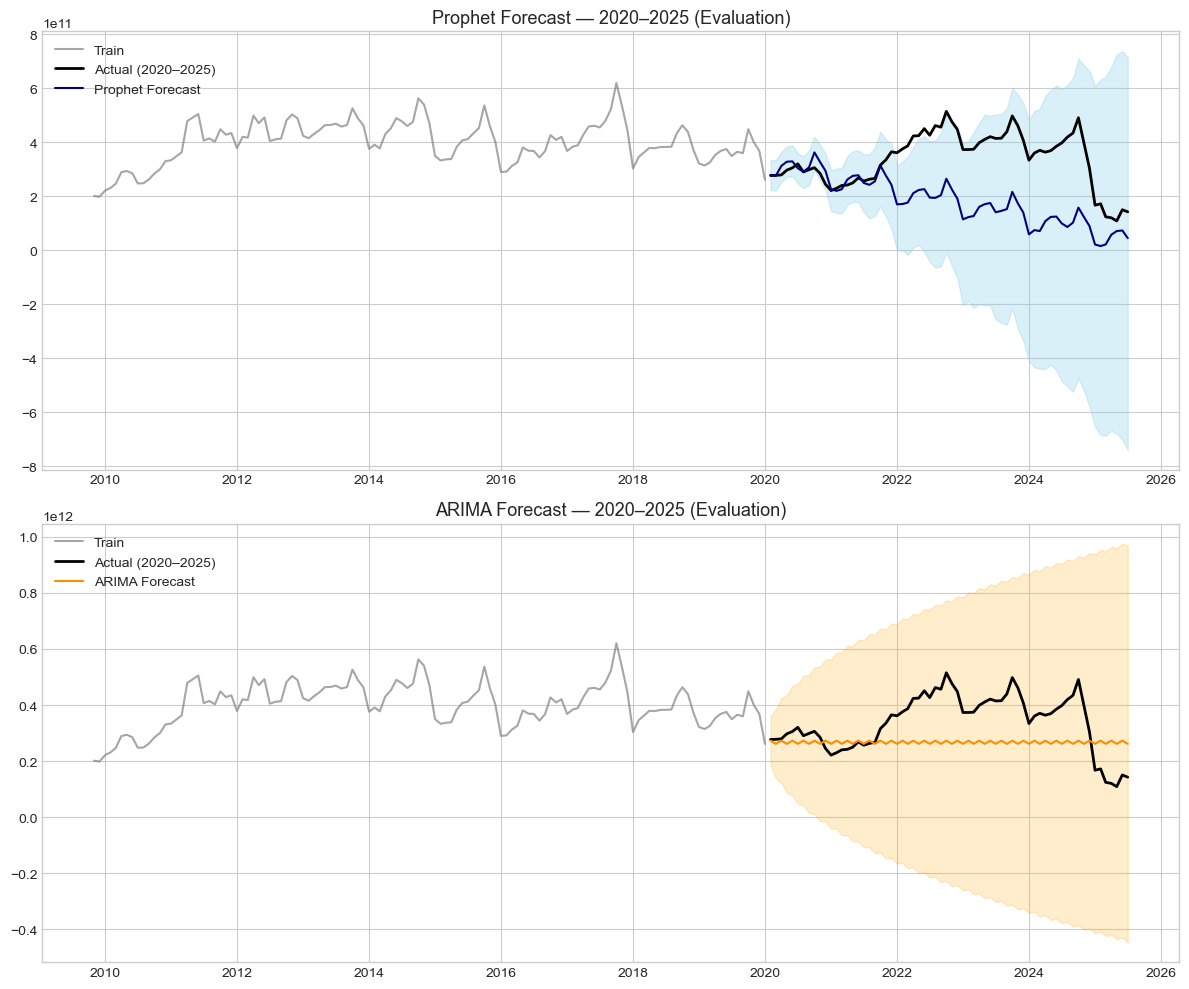

In [ ]:
# KENYA AID FORECASTING (2020–2025)
# =======================================================

# --- PREPARE DATA ---
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df = df.dropna(subset=['transaction_date', 'total_agency_aid'])

# Monthly aggregation
monthly = (
    df.groupby(pd.Grouper(key='transaction_date', freq='M'))['total_agency_aid']
    .sum()
    .reset_index()
    .rename(columns={'transaction_date': 'ds', 'total_agency_aid': 'y'})
)

# Smoothing to reduce volatility
monthly['y'] = monthly['y'].rolling(window=3, min_periods=1).mean()
monthly = monthly.sort_values('ds').reset_index(drop=True)

print(f"Records: {len(monthly)} | Range: {monthly['ds'].min().date()} → {monthly['ds'].max().date()}")

# --- DEFINE TRAIN/TEST SPLIT ---
train = monthly[monthly['ds'] < '2020-01-01']
test = monthly[(monthly['ds'] >= '2020-01-01') & (monthly['ds'] <= '2025-12-31')]

print(f"Train period: {train['ds'].min().date()} → {train['ds'].max().date()} ({len(train)} months)")
print(f"Test period : {test['ds'].min().date()} → {test['ds'].max().date()} ({len(test)} months)")

# --- PROPHET MODEL ---
model_prophet = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=1.0,
    interval_width=0.9
)
model_prophet.fit(train)
future = model_prophet.make_future_dataframe(periods=len(test), freq='M')
forecast_prophet = model_prophet.predict(future)

# Prophet predictions aligned with test set
pred_prophet = forecast_prophet.set_index('ds').loc[test['ds'], 'yhat']

# --- ARIMA MODEL ---
arima_model = ARIMA(train['y'], order=(1, 1, 1))
arima_result = arima_model.fit()
forecast_arima = arima_result.get_forecast(steps=len(test))
pred_arima = forecast_arima.predicted_mean
ci_arima = forecast_arima.conf_int()
pred_arima.index = test['ds']

# --- EVALUATION METRICS ---
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_p, rmse_p = metrics(test['y'], pred_prophet)
mae_a, rmse_a = metrics(test['y'], pred_arima)

print("\n--- MODEL PERFORMANCE (2020–2025) ---")
print(f"Prophet → MAE: {mae_p:,.2f} | RMSE: {rmse_p:,.2f}")
print(f"ARIMA   → MAE: {mae_a:,.2f} | RMSE: {rmse_a:,.2f}")

# --- VISUALIZATION ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Prophet Forecast
axes[0].plot(train['ds'], train['y'], label='Train', color='gray', alpha=0.7)
axes[0].plot(test['ds'], test['y'], label='Actual (2020–2025)', color='black', linewidth=2)
axes[0].plot(pred_prophet.index, pred_prophet, color='navy', label='Prophet Forecast')
axes[0].fill_between(
    forecast_prophet.set_index('ds').loc[test['ds'], :].index,
    forecast_prophet.set_index('ds').loc[test['ds'], 'yhat_lower'],
    forecast_prophet.set_index('ds').loc[test['ds'], 'yhat_upper'],
    color='skyblue', alpha=0.3
)
axes[0].set_title('Prophet Forecast — 2020–2025', fontsize=13)
axes[0].legend()

# ARIMA Forecast
axes[1].plot(train['ds'], train['y'], label='Train', color='gray', alpha=0.7)
axes[1].plot(test['ds'], test['y'], label='Actual (2020–2025)', color='black', linewidth=2)
axes[1].plot(pred_arima.index, pred_arima, color='darkorange', label='ARIMA Forecast')
axes[1].fill_between(pred_arima.index, ci_arima.iloc[:, 0], ci_arima.iloc[:, 1], color='orange', alpha=0.2)
axes[1].set_title('ARIMA Forecast — 2020–2025', fontsize=13)
axes[1].legend()

plt.tight_layout()
plt.show()

2025-10-31 13:40:14,228 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:14,368 DEBUG TBB already found in load path
2025-10-31 13:40:14,385 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\0hao99w0.json
2025-10-31 13:40:14,394 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\q1r76rov.json
2025-10-31 13:40:14,399 DEBUG idx 0
2025-10-31 13:40:14,400 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:14,401 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=85667', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\0hao99w0.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\q1r76rov.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_modelve1upo7j\\prophet_model-20251031134014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:40:14 - cmdstanpy - INFO - Chain [1] start 

✅ Forecasted: Agriculture


13:40:15 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:15,240 INFO Chain [1] done processing
2025-10-31 13:40:15,461 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:15,562 DEBUG TBB already found in load path
2025-10-31 13:40:15,578 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\ucr3610r.json
2025-10-31 13:40:15,588 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\3crg9zhu.json
2025-10-31 13:40:15,591 DEBUG idx 0
2025-10-31 13:40:15,592 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:15,592 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=28780', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\ucr3610r.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\3crg9zhu.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_model93zi4h3_\\prophet_model-20251031

✅ Forecasted: Development


13:40:15 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:15,815 INFO Chain [1] done processing
2025-10-31 13:40:15,939 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:16,040 DEBUG TBB already found in load path
2025-10-31 13:40:16,058 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\ctwpcwlo.json
2025-10-31 13:40:16,067 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\qdi9tfec.json
2025-10-31 13:40:16,070 DEBUG idx 0
2025-10-31 13:40:16,071 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:16,071 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=71614', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\ctwpcwlo.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\qdi9tfec.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_modelp6surs9c\\prophet_model-20251031

✅ Forecasted: Economy


13:40:16 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:16,303 INFO Chain [1] done processing
2025-10-31 13:40:16,406 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:16,505 DEBUG TBB already found in load path
2025-10-31 13:40:16,521 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\zwcktbz0.json
2025-10-31 13:40:16,529 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\wcclr9bo.json
2025-10-31 13:40:16,531 DEBUG idx 0
2025-10-31 13:40:16,532 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:16,533 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98679', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\zwcktbz0.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\wcclr9bo.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_model3g96v90s\\prophet_model-20251031

✅ Forecasted: Education


13:40:16 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:16,638 INFO Chain [1] done processing
2025-10-31 13:40:16,773 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:16,874 DEBUG TBB already found in load path
2025-10-31 13:40:16,890 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\7s9lbczx.json
2025-10-31 13:40:16,898 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\s7o75i1x.json
2025-10-31 13:40:16,899 DEBUG idx 0
2025-10-31 13:40:16,900 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:16,901 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=31596', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\7s9lbczx.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\s7o75i1x.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_modeli4tbmbjz\\prophet_model-20251031

✅ Forecasted: Environment


13:40:17 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:17,142 INFO Chain [1] done processing
2025-10-31 13:40:17,242 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:17,345 DEBUG TBB already found in load path
2025-10-31 13:40:17,359 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\gbht1gvr.json
2025-10-31 13:40:17,368 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\g4b6rmz8.json
2025-10-31 13:40:17,370 DEBUG idx 0
2025-10-31 13:40:17,371 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:17,372 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=55045', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\gbht1gvr.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\g4b6rmz8.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_modelkf08l494\\prophet_model-20251031

✅ Forecasted: Health


13:40:17 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:17,574 INFO Chain [1] done processing
2025-10-31 13:40:17,737 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:17,840 DEBUG TBB already found in load path
2025-10-31 13:40:17,855 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\l_cxdsis.json
2025-10-31 13:40:17,863 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\2jmmi5he.json
2025-10-31 13:40:17,865 DEBUG idx 0
2025-10-31 13:40:17,866 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:17,866 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=65144', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\l_cxdsis.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\2jmmi5he.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_model6k4vqxh7\\prophet_model-20251031

✅ Forecasted: Human Rights


13:40:18 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:18,027 INFO Chain [1] done processing
2025-10-31 13:40:18,143 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:18,236 DEBUG TBB already found in load path
2025-10-31 13:40:18,252 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\4yvncofq.json
2025-10-31 13:40:18,260 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\tshqz4_z.json
2025-10-31 13:40:18,336 DEBUG idx 0


✅ Forecasted: Other/Unspecified


2025-10-31 13:40:18,339 DEBUG running CmdStan, num_threads: None
2025-10-31 13:40:18,341 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=91719', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\4yvncofq.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\tshqz4_z.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_modelhsqjiodx\\prophet_model-20251031134018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:40:18 - cmdstanpy - INFO - Chain [1] start processing
2025-10-31 13:40:18,343 INFO Chain [1] start processing
13:40:18 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:18,541 INFO Chain [1] done processing
2025-10-31 13:40:18,677 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:40:18,777 DEBUG TBB already found in load path
2025-10-31 13:40:18,792 DEBUG input tempfile: C:\Users\lenovo\AppData\Lo

✅ Forecasted: Politics


13:40:19 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:40:19,011 INFO Chain [1] done processing


✅ Forecasted: Security

✅ Total successful forecasts: 10


,Sector,Prophet_MAE,Prophet_RMSE,ARIMA_MAE,ARIMA_RMSE
0,Development,5.613837e+08,6.198419e+08,1.716125e+07,3.307847e+07
1,Economy,3.083128e+09,3.541721e+09,8.631704e+08,8.905692e+08
2,Agriculture,3.815179e+09,4.536246e+09,4.713064e+09,5.871192e+09
3,Education,4.907792e+09,5.764753e+09,1.354022e+09,1.634809e+09
4,Security,8.884805e+09,9.900138e+09,1.434067e+09,1.716419e+09
5,Human Rights,1.195109e+10,1.558952e+10,5.645903e+09,7.930228e+09
6,Environment,1.342836e+10,1.568144e+10,1.911311e+09,1.992220e+09
7,Politics,2.181153e+10,2.547205e+10,2.678373e+09,3.063974e+09
8,Health,4.358902e+10,4.990073e+10,7.125057e+10,8.027051e+10
9,Other/Unspecified,8.153294e+10,9.824802e+10,4.966931e+10,5.842095e+10


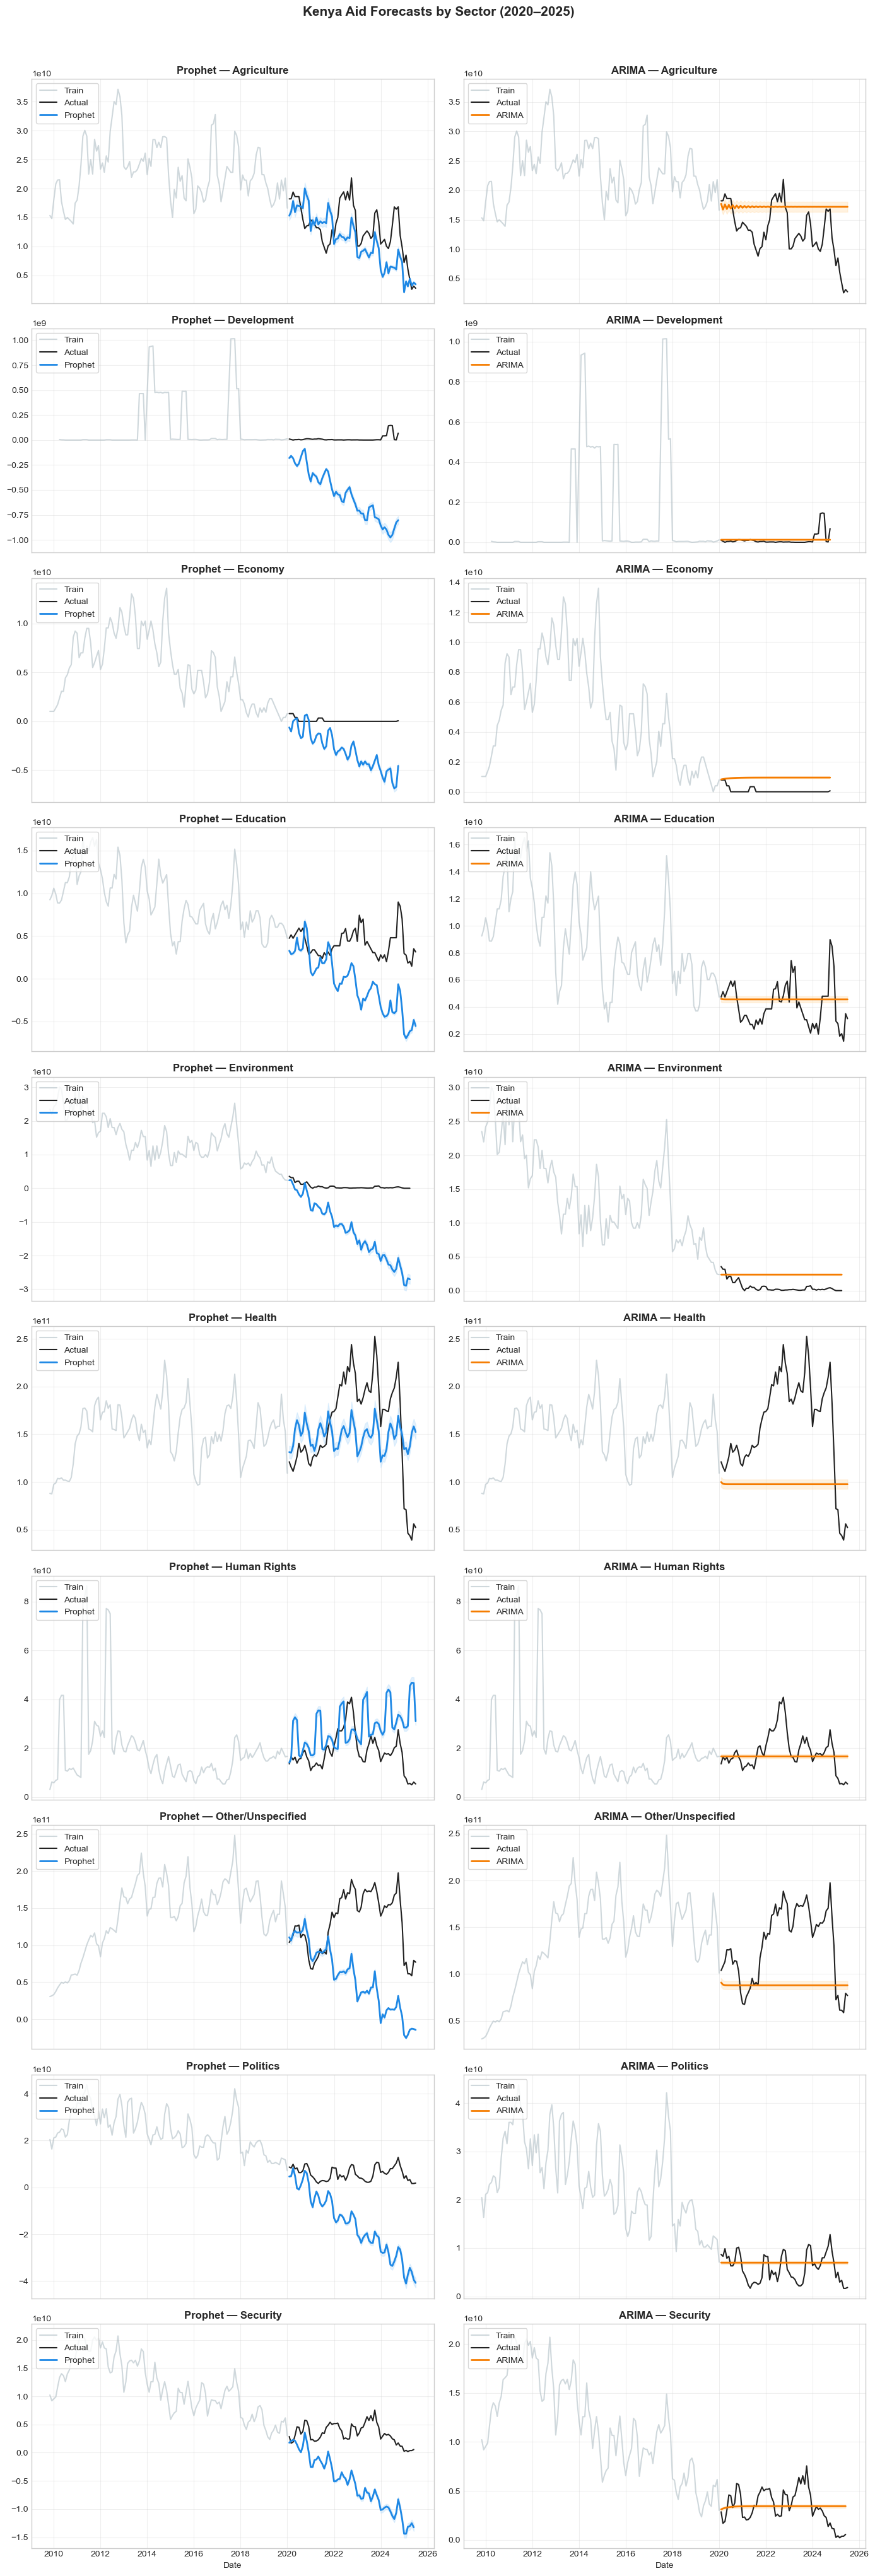

In [ ]:
# FORECASTING 2020–2025 FOR ALL SECTORS
# Prophet + ARIMA Evaluation 
# =======================================================

# --- PREPARE DATA ---
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df = df.dropna(subset=['transaction_date', 'total_agency_aid', 'us_sector_name'])

EVAL_START = '2020-01-01'
EVAL_END = '2025-12-31'

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# --- FORECASTING FUNCTION ---
def forecast_sector(sector_df, sector_name):
    monthly = (
        sector_df.groupby(pd.Grouper(key='transaction_date', freq='M'))['total_agency_aid']
        .sum()
        .reset_index()
        .rename(columns={'transaction_date': 'ds', 'total_agency_aid': 'y'})
    )

    if len(monthly) < 24:
        return None

    monthly['y'] = monthly['y'].rolling(window=3, min_periods=1).mean()
    monthly = monthly.sort_values('ds').reset_index(drop=True)

    train = monthly[monthly['ds'] < EVAL_START]
    test = monthly[(monthly['ds'] >= EVAL_START) & (monthly['ds'] <= EVAL_END)]

    if len(test) == 0 or len(train) < 24:
        return None

    # Prophet
    model_prophet = Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=1.0,
        interval_width=0.9
    )
    model_prophet.fit(train)
    future = model_prophet.make_future_dataframe(periods=len(test), freq='M')
    forecast_prophet = model_prophet.predict(future)
    pred_prophet = forecast_prophet.set_index('ds').loc[test['ds'], 'yhat']

    # ARIMA
    try:
        arima_model = ARIMA(train['y'], order=(1, 1, 1))
        arima_result = arima_model.fit()
        forecast_arima = arima_result.get_forecast(steps=len(test))
        pred_arima = forecast_arima.predicted_mean
        pred_arima.index = test['ds']
    except:
        return None

    mae_p, rmse_p = metrics(test['y'], pred_prophet)
    mae_a, rmse_a = metrics(test['y'], pred_arima)

    return {
        'sector': sector_name,
        'train': train,
        'test': test,
        'pred_prophet': pred_prophet,
        'pred_arima': pred_arima,
        'metrics': {
            'Prophet_MAE': mae_p, 'Prophet_RMSE': rmse_p,
            'ARIMA_MAE': mae_a, 'ARIMA_RMSE': rmse_a
        }
    }

# --- RUN FORECASTS ---
sector_results = []
for sector_name, sector_df in df.groupby('us_sector_name'):
    res = forecast_sector(sector_df, sector_name)
    if res:
        sector_results.append(res)
        print(f"Forecasted: {sector_name}")

print(f"\nTotal successful forecasts: {len(sector_results)}")

# --- PERFORMANCE TABLE ---
performance = pd.DataFrame([r['metrics'] | {'Sector': r['sector']} for r in sector_results])
performance = performance[['Sector', 'Prophet_MAE', 'Prophet_RMSE', 'ARIMA_MAE', 'ARIMA_RMSE']]
performance = performance.sort_values('Prophet_RMSE').reset_index(drop=True)
display(performance)

# --- VISUALIZATION (ALL SECTORS) ---
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.titleweight": "bold",
    "legend.frameon": True
})

rows = len(sector_results)
fig, axes = plt.subplots(rows, 2, figsize=(14, 4 * rows), sharex=True)

if rows == 1:
    axes = np.array([axes])  # ensure iterable structure

for i, res in enumerate(sector_results):
    train, test = res['train'], res['test']
    pred_prophet, pred_arima = res['pred_prophet'], res['pred_arima']
    sector_name = res['sector']

    # Prophet Plot
    ax1 = axes[i, 0]
    ax1.plot(train['ds'], train['y'], color='#B0BEC5', alpha=0.6, label='Train')
    ax1.plot(test['ds'], test['y'], color='#212121', label='Actual')
    ax1.plot(pred_prophet.index, pred_prophet, color='#1E88E5', linewidth=2, label='Prophet')
    ax1.fill_between(pred_prophet.index, pred_prophet * 0.95, pred_prophet * 1.05, color='#BBDEFB', alpha=0.4)
    ax1.set_title(f"Prophet — {sector_name}")
    ax1.legend(loc='upper left')

    # ARIMA Plot
    ax2 = axes[i, 1]
    ax2.plot(train['ds'], train['y'], color='#B0BEC5', alpha=0.6, label='Train')
    ax2.plot(test['ds'], test['y'], color='#212121', label='Actual')
    ax2.plot(pred_arima.index, pred_arima, color='#F57C00', linewidth=2, label='ARIMA')
    ax2.fill_between(pred_arima.index, pred_arima * 0.95, pred_arima * 1.05, color='#FFE0B2', alpha=0.4)
    ax2.set_title(f"ARIMA — {sector_name}")
    ax2.legend(loc='upper left')

for ax in axes[-1, :]:
    ax.set_xlabel("Date")

plt.tight_layout()
plt.suptitle("Kenya Aid Forecasts by Sector (2020–2025)", fontsize=15, weight='bold', y=1.02)
plt.show()


2025-10-31 13:34:52,761 DEBUG cmd: where.exe tbb.dll
cwd: None
2025-10-31 13:34:52,862 DEBUG TBB already found in load path
2025-10-31 13:34:52,879 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\wbvhq5ln.json
2025-10-31 13:34:52,886 DEBUG input tempfile: C:\Users\lenovo\AppData\Local\Temp\tmpdfvhlyce\pdfwlg1k.json
2025-10-31 13:34:52,962 DEBUG idx 0


Records: 189 | Range: 2009-10-31 → 2025-06-30
Train: 2009-10-31 → 2019-12-31 (123 months)
Test : 2020-01-31 → 2025-06-30 (66 months)


2025-10-31 13:34:52,964 DEBUG running CmdStan, num_threads: None
2025-10-31 13:34:52,965 DEBUG CmdStan args: ['C:\\Users\\lenovo\\anaconda3\\envs\\ds-env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=68601', 'data', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\wbvhq5ln.json', 'init=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\pdfwlg1k.json', 'output', 'file=C:\\Users\\lenovo\\AppData\\Local\\Temp\\tmpdfvhlyce\\prophet_modelbrqq7cdj\\prophet_model-20251031133452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:34:52 - cmdstanpy - INFO - Chain [1] start processing
2025-10-31 13:34:52,967 INFO Chain [1] start processing
13:34:53 - cmdstanpy - INFO - Chain [1] done processing
2025-10-31 13:34:53,064 INFO Chain [1] done processing



--- MODEL PERFORMANCE (2020–2025) ---
Prophet → MAE: 159,967,086,608.36 | RMSE: 196,858,960,102.79
ARIMA   → MAE: 102,372,503,484.29 | RMSE: 121,381,490,215.90


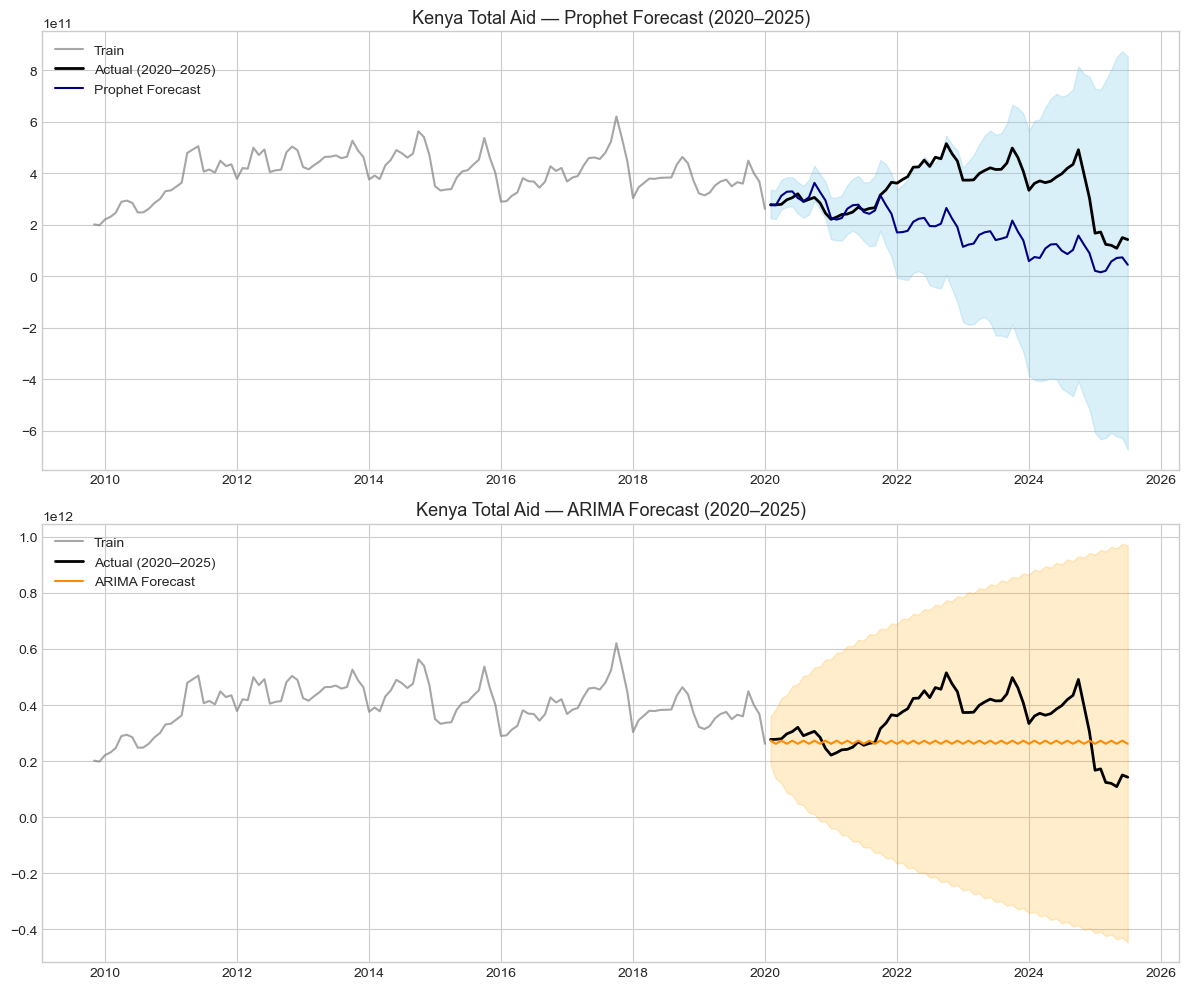

In [ ]:
# TOTAL AID FORECASTING (2020–2025)
# Prophet + ARIMA Evaluation
# =======================================================

# --- PREPARE DATA ---
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df = df.dropna(subset=['transaction_date', 'total_agency_aid'])

# Aggregate at monthly level
monthly_total = (
    df.groupby(pd.Grouper(key='transaction_date', freq='M'))['total_agency_aid']
    .sum()
    .reset_index()
    .rename(columns={'transaction_date': 'ds', 'total_agency_aid': 'y'})
)

# Smooth short-term spikes (3-month rolling mean)
monthly_total['y'] = monthly_total['y'].rolling(window=3, min_periods=1).mean()
monthly_total = monthly_total.sort_values('ds').reset_index(drop=True)

print(f"Records: {len(monthly_total)} | Range: {monthly_total['ds'].min().date()} → {monthly_total['ds'].max().date()}")

# --- SPLIT TRAIN & TEST ---
EVAL_START = '2020-01-01'
EVAL_END = '2025-12-31'

train = monthly_total[monthly_total['ds'] < EVAL_START]
test = monthly_total[(monthly_total['ds'] >= EVAL_START) & (monthly_total['ds'] <= EVAL_END)]

print(f"Train: {train['ds'].min().date()} → {train['ds'].max().date()} ({len(train)} months)")
print(f"Test : {test['ds'].min().date()} → {test['ds'].max().date()} ({len(test)} months)")

# --- PROPHET MODEL ---
model_p = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=1.0,
    interval_width=0.9
)
model_p.fit(train)
future = model_p.make_future_dataframe(periods=len(test), freq='M')
forecast_p = model_p.predict(future)

# Prophet predictions aligned with test
pred_p = forecast_p.set_index('ds').loc[test['ds'], 'yhat']

# --- ARIMA MODEL ---
arima_model = ARIMA(train['y'], order=(1, 1, 1))
arima_res = arima_model.fit()
forecast_a = arima_res.get_forecast(steps=len(test))
pred_a = forecast_a.predicted_mean
ci_a = forecast_a.conf_int()
pred_a.index = test['ds']

# --- METRICS ---
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_p, rmse_p = metrics(test['y'], pred_p)
mae_a, rmse_a = metrics(test['y'], pred_a)

print("\n--- MODEL PERFORMANCE (2020–2025) ---")
print(f"Prophet → MAE: {mae_p:,.2f} | RMSE: {rmse_p:,.2f}")
print(f"ARIMA   → MAE: {mae_a:,.2f} | RMSE: {rmse_a:,.2f}")

# --- VISUALIZATION ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Prophet
axes[0].plot(train['ds'], train['y'], label='Train', color='gray', alpha=0.7)
axes[0].plot(test['ds'], test['y'], label='Actual (2020–2025)', color='black', linewidth=2)
axes[0].plot(pred_p.index, pred_p, color='navy', label='Prophet Forecast')
axes[0].fill_between(
    forecast_p.set_index('ds').loc[test['ds'], :].index,
    forecast_p.set_index('ds').loc[test['ds'], 'yhat_lower'],
    forecast_p.set_index('ds').loc[test['ds'], 'yhat_upper'],
    color='skyblue', alpha=0.3
)
axes[0].set_title('Kenya Total Aid — Prophet Forecast (2020–2025)', fontsize=13)
axes[0].legend()

# ARIMA
axes[1].plot(train['ds'], train['y'], label='Train', color='gray', alpha=0.7)
axes[1].plot(test['ds'], test['y'], label='Actual (2020–2025)', color='black', linewidth=2)
axes[1].plot(pred_a.index, pred_a, color='darkorange', label='ARIMA Forecast')
axes[1].fill_between(pred_a.index, ci_a.iloc[:, 0], ci_a.iloc[:, 1], color='orange', alpha=0.2)
axes[1].set_title('Kenya Total Aid — ARIMA Forecast (2020–2025)', fontsize=13)
axes[1].legend()

plt.tight_layout()
plt.show()


,total_aid_fiscal
fiscal_year,
2010,5.085981e+12
2011,7.757711e+12
2012,8.530928e+12
2013,1.063417e+13
2014,9.717861e+12


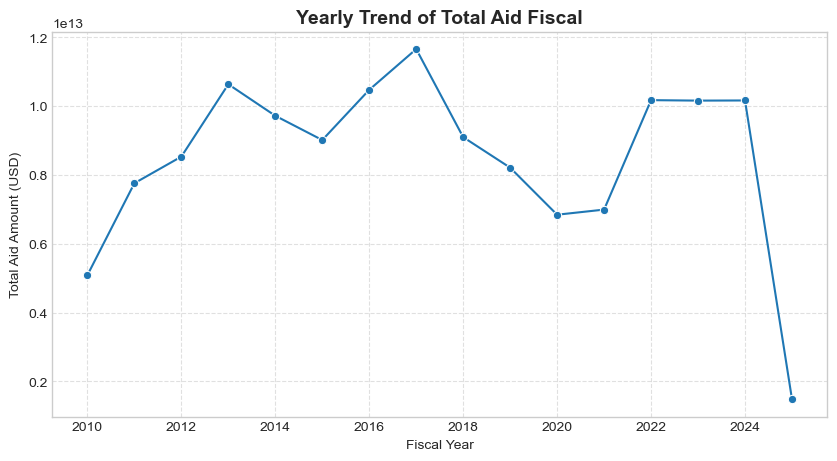

In [18]:
# ------- [Predictive Forecasting Preparation - Fixed] -------

# Define date and target columns
date_col = 'transaction_date'
target_col = 'total_aid_fiscal'  # try 'current_dollar_amount' or 'constant_dollar_amount' as well

# Aggregate data by fiscal year (or month if more granular)
time_series = (
    df.groupby('fiscal_year')[target_col]
      .sum()
      .reset_index()
      .sort_values('fiscal_year')
)

# Set fiscal_year as index
time_series = time_series.set_index('fiscal_year')

# Display sample
display(time_series.head())

# Plot baseline trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=time_series.index, y=target_col, data=time_series, marker='o')
plt.title(f"Yearly Trend of {target_col.replace('_', ' ').title()}", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: 

ARIMA Forecast Performance (Total Aid Fiscal)
MAE:  3,447,374,321,651.35
RMSE: 5,337,969,594,869.29


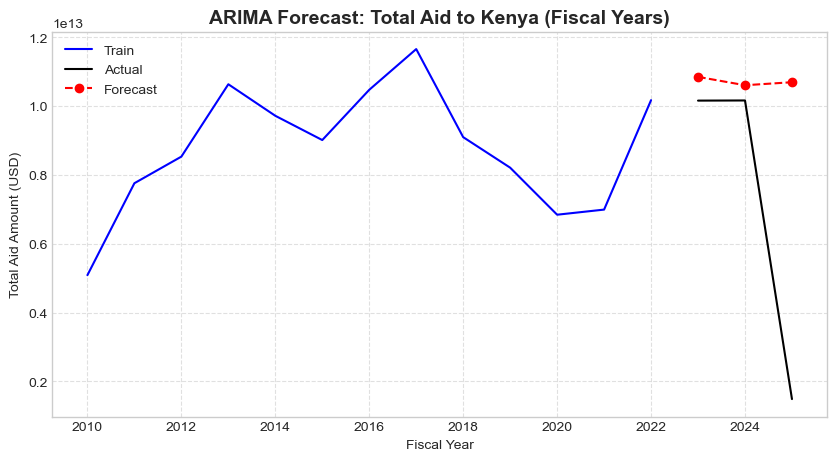

In [4]:
# ------- [Baseline ARIMA Forecast - Total Aid Fiscal] -------

# Extract target time series
ts = time_series['total_aid_fiscal']

# Split into train and test (last 3 fiscal years for testing)
train = ts.iloc[:-3]
test = ts.iloc[-3:]

# Fit ARIMA model (baseline)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

# Evaluate model
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA Forecast Performance (Total Aid Fiscal)")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--', marker='o')
plt.title("ARIMA Forecast: Total Aid to Kenya (Fiscal Years)", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet Forecast Performance (Total Aid Fiscal)
MAE:  3,776,568,081,080.20
RMSE: 4,475,886,959,496.08


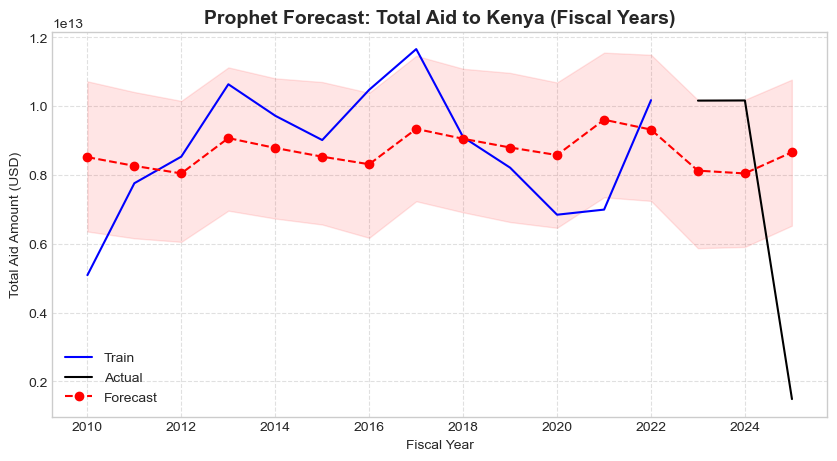

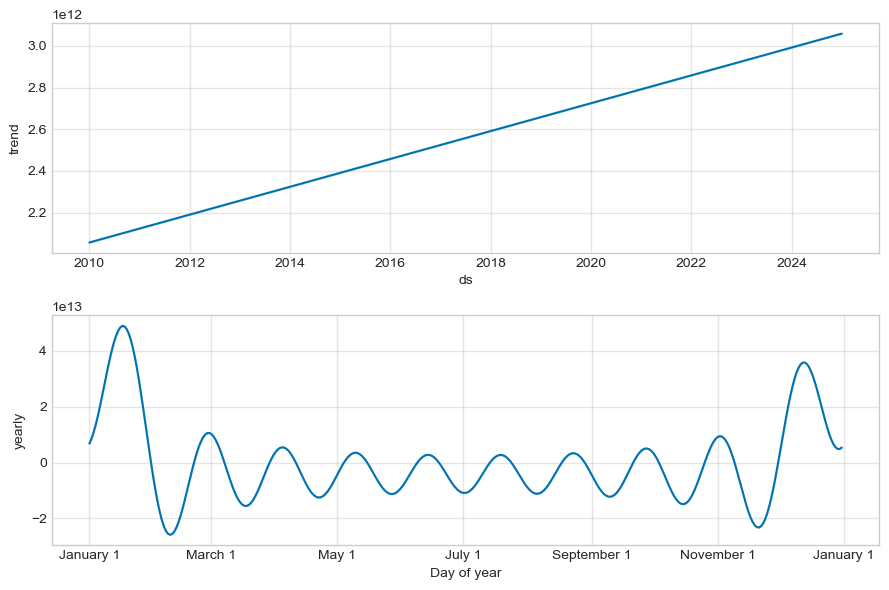

In [5]:
# ------- [Prophet Forecast - Total Aid Fiscal] -------

# Prepare data for Prophet
prophet_df = time_series.reset_index().rename(columns={'fiscal_year': 'ds', 'total_aid_fiscal': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Split into train and test (last 3 fiscal years)
train = prophet_df.iloc[:-3]
test = prophet_df.iloc[-3:]

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='additive'
)
model.fit(train)

# Create future dataframe by extending 3 years beyond test
future = model.make_future_dataframe(periods=3, freq='Y')
forecast = model.predict(future)

# Evaluate forecast by aligning dates
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
eval_df = pd.merge_asof(
    test.sort_values('ds'),
    forecast_df.sort_values('ds'),
    on='ds',
    direction='nearest'
)

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))

print("Prophet Forecast Performance (Total Aid Fiscal)")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Train', color='blue')
plt.plot(test['ds'], test['y'], label='Actual', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--', marker='o')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)
plt.title("Prophet Forecast: Total Aid to Kenya (Fiscal Years)", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 7Trend and seasonality decomposition
model.plot_components(forecast)
plt.show()